In [1]:
!pip install fastbook

     |████████████████████████████████| 719 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 39.8 MB/s 
     |████████████████████████████████| 197 kB 51.0 MB/s 
     |████████████████████████████████| 60 kB 6.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastbook import *
from fastai import *
from fastai.vision.widgets import *

In [3]:
people_type = 'female','male'
path = Path('people')

In [4]:
if not path.exists():
  path.mkdir()
  for o in people_type:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'face of {o}',max_images=50)
    download_images(dest,urls=results,max_pics=50)

In [5]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#2) [None,None]

In [6]:
people = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [7]:
people = people.new(
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = people.dataloaders(path)

In [11]:
learn = vision_learner(dls,resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.343036,0.836001,0.578947,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.817528,0.500065,0.631579,00:10
1,0.739664,0.354343,0.894737,00:10
2,0.546188,0.295615,0.947368,00:10
3,0.412972,0.246584,0.947368,00:10
4,0.346233,0.199923,0.947368,00:10


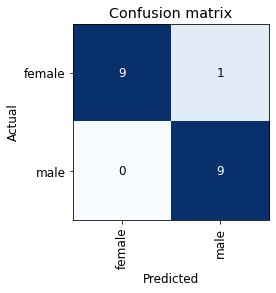

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

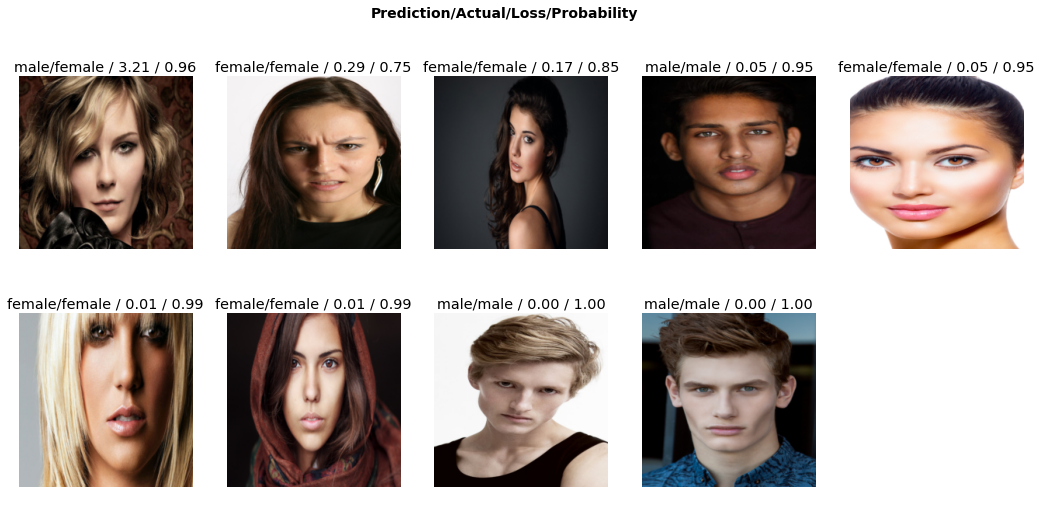

In [14]:
interp.plot_top_losses(10, nrows=2, figsize=(18,8))
plt.rcParams.update({'font.size': 8})

In [15]:
interp.most_confused()

[('female', 'male', 1)]

In [16]:
learn.export()

In [17]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [18]:
learn_inf = load_learner(path/'export.pkl')

In [19]:
learn_inf.dls.vocab

['female', 'male']

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
img = PILImage.create(btn_upload.data[-1])

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [31]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [32]:
pred,pred_idx,probs = learn_inf.predict(img)

In [34]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: male; Probability: 0.9986')

In [35]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [26]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [36]:
VBox([widgets.Label('Upload a picture'), 
      btn_upload, btn_run, out_pl, lbl_pred])